In [21]:
import os
import sys
import pprint
import PyPDF2
import pretty_errors
from dotenv import load_dotenv
from unstructured.partition.pdf import partition_pdf

In [26]:
dotenv_path = os.path.abspath(os.path.join('..', '.env'))

try:
    load_dotenv(dotenv_path)
    print(f".env loaded from: {dotenv_path}")
except Exception as e:
    print(f"Failed to load .env file: {e}")

.env loaded from: /workspaces/software_effort_estimation_rag/.env


The PDF contains several pages with irrelevant or uninformative content. To optimize processing, we will first identify and select only the relevant pages before extracting elements from them.

In [2]:
import tempfile
from io import BytesIO

irrelevant_content_pages = list(range(0, 8)) + list(range(51, 54))

with open('../see_report.pdf', 'rb') as file:
    reader = PyPDF2.PdfReader(file)
    total_pages = len(reader.pages)
    writer = PyPDF2.PdfWriter()
 
    remaining_pages = filter(lambda x: x not in irrelevant_content_pages, range(total_pages))   

    for page_num in remaining_pages:
        writer.add_page(reader.pages[page_num])
    
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.pdf')
    writer.write(temp_file)
    temp_file.close()

In [3]:
raw_pdf_elements = partition_pdf(
    temp_file.name, 
    strategy='hi_res',
    extract_images_in_pdf=True,
    infer_table_structure=True,

    extract_image_block_types=["Image"],   
    
    extract_image_block_to_payload=True,
    
    max_characters=10000,
    new_after_n_chars=6000,
    
    languages=['eng'],
)

os.unlink(temp_file.name)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [ ]:
import re
from tqdm import tqdm
from unstructured.documents.elements import Table, Image, NarrativeText, FigureCaption, Formula

table_caption_pattern = re.compile(r'^Table \d+\.\d+: ')
image_caption_pattern = re.compile(r'^Figure \d+\.\d+: ')

texts, tables, images = [], [], []
formulas, table_captions, image_captions = [], [], []

for element in tqdm(raw_pdf_elements):
    text = getattr(element, "text", "")

    if isinstance(element, (FigureCaption, NarrativeText)):
        if table_caption_pattern.match(text):
            table_captions.append(text)
        elif image_caption_pattern.match(text):
            image_captions.append(text)
        elif isinstance(element, NarrativeText):
            texts.append(text)

    elif isinstance(element, Table):
        tables.append(element) # Add the table as html for more clarity

    elif isinstance(element, Image):
        images.append(element)

    elif isinstance(element, Formula):
        formulas.append(text)

100%|██████████| 741/741 [00:00<00:00, 403476.47it/s]


In [5]:
print("No of Textual Chunks:", len(texts))
print("No of Table Elements:", len(tables))
print("No of Images:", len(images))

No of Textual Chunks: 168
No of Table Elements: 11
No of Images: 45


In [29]:
for table in tables:
    print('*'*150)
    print('*'*50 + ' Table as text' + '*'*50)
    pprint.pprint(table.text)
    #print('*'*50 + ' Table as html' + '*'*50)
    #pprint.pprint(table.metadata.text_as_html)
    print('\n\n')

******************************************************************************************************************************************************
************************************************** Table as text**************************************************
('Title Year Journal/Conference [2] Software Development Effort Estimation '
 '2017 Int’l Journal of Computing, Communications Using Ensemble Machine '
 'Learning Instrumentation Engg. [3] Predictive analytics approaches for 2020 '
 'Indian Journal of Science an Technology software effort estimation: A review '
 '[4] Comparative Analysis on prediction of Software 2020 SSRN Electronic '
 'Journal Effort Estimation Using Machine Learning Techniques [5] Software '
 'Effort Estimation 2014 Indian Software engineering Conference Using Machine '
 'Learning Techniques GA-based method for feature selection and [6] parameters '
 'optimization for Machine Learning 2010 Indian Software engineering '
 'Conference regression applied to s

In [9]:
# Filter retrieved chunks that only contains page numbers

texts = list(filter(lambda x: 'Page' not in x, texts))
len(texts)

123

In [10]:
for i, text in enumerate(texts[:10]):
    pprint.pp('-'*20 + f'Text {i+1}' + '-'*20)
    pprint.pp(text)
    print('\n\n')

'--------------------Text 1--------------------'
('Nowadays, the use of software grows continuously. So, to keep up with this '
 'growth, companies must produce software of high quality and in time. The '
 'success of a software development project requires a good and early '
 'planning. Therefore, planning has become an important phase in each software '
 'development process. Among the planning phases that contribute to the '
 'success of a software development project, there is Estimation of Effort.')



'--------------------Text 2--------------------'
('In software engineering, Effort Estimation has become an important task for '
 'companies. It is the process of forecasting how much effort is required to '
 'develop or maintain a software application. This effort is traditionally '
 'measured in the hours worked by a person, or the money needed to pay for '
 'this work (Cost). Effort estimation helps draft project plans and budgets in '
 'the early stages of the software developme

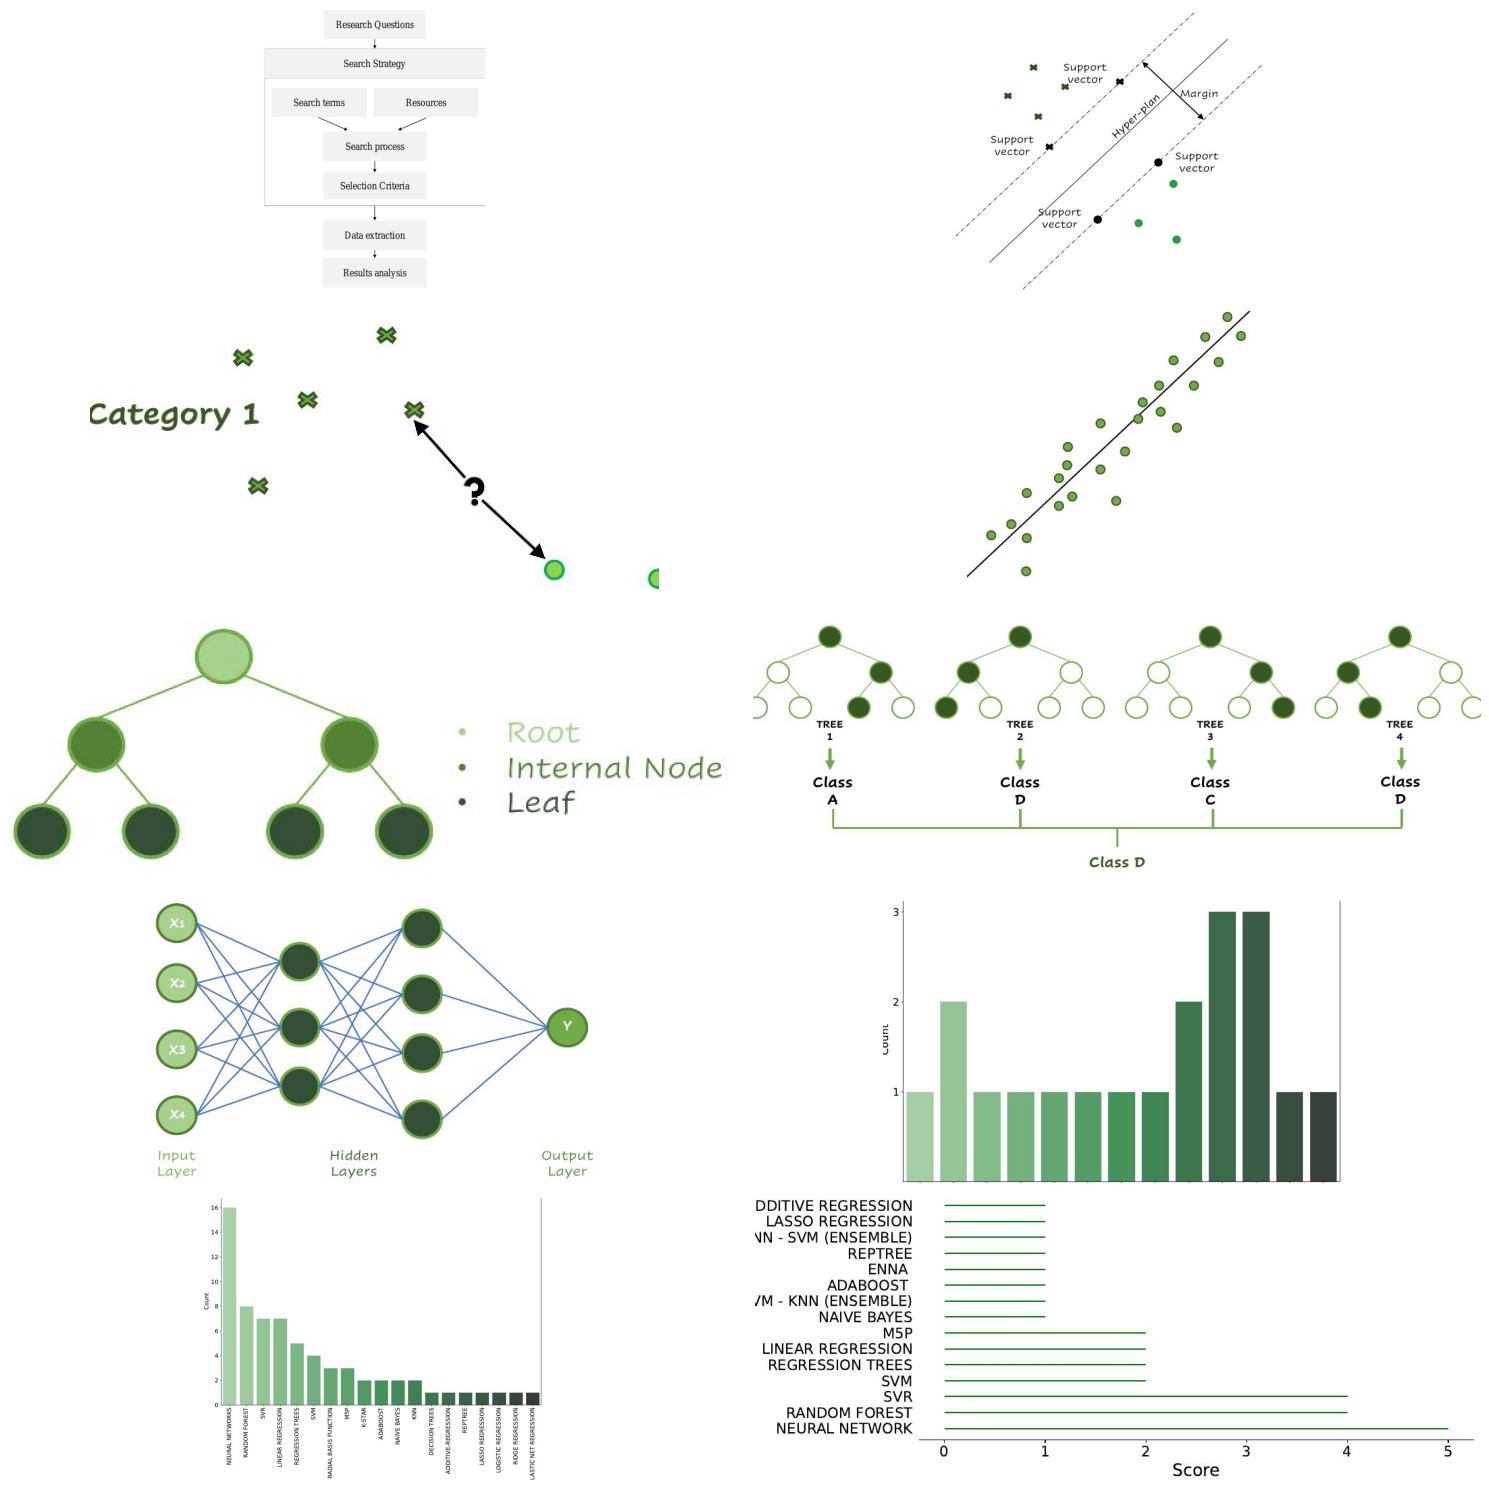

In [36]:
import base64
from io import BytesIO
from PIL import Image as PILImage
import matplotlib.pyplot as plt

sample = 10
base64_images = [el.metadata.image_base64 for el in images]
fig, axs = plt.subplots(sample // 2, 2, figsize=(15, 15))
axs = axs.flatten()

for i, image_b64 in enumerate(base64_images[:sample]):
    image_data = base64.b64decode(image_b64)
    image = PILImage.open(BytesIO(image_data))
    axs[i].imshow(image)
    axs[i].axis('off') 


for j in range(len(base64_images[:sample]), len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


In [37]:
assert len(tables) == len(table_captions)

tables_with_captions = {cap.split(':')[1]: table for cap, table in zip(table_captions, tables)}
pprint.pprint(tables_with_captions)

{' Anova test results': <unstructured.documents.elements.Table object at 0x76240e0bbef0>,
 ' Best Hyperparamters': <unstructured.documents.elements.Table object at 0x76240e0f67b0>,
 ' Description of hyper-parameters': <unstructured.documents.elements.Table object at 0x76240e0f6d50>,
 ' Dropped columns based on null values percentage': <unstructured.documents.elements.Table object at 0x76240e0bb980>,
 ' F regression test results': <unstructured.documents.elements.Table object at 0x76240e0c5940>,
 ' General information about genetic algorithms results': <unstructured.documents.elements.Table object at 0x76240e0f5430>,
 ' General information of analyzed papers': <unstructured.documents.elements.Table object at 0x76240e0434d0>,
 ' New dataset features': <unstructured.documents.elements.Table object at 0x76240e0ce990>,
 ' Questionnaire subsections': <unstructured.documents.elements.Table object at 0x76240e04fec0>,
 ' SEERA dataset attributes': <unstructured.documents.elements.Table object a

# Summarizing tables

In [38]:
prompt_text = """You are a content editor who specializes in summarizing tables from research reports, articles, or technical documents.

I will give you one or more tables in plain text format. Each table may contain information such as:
- Results of experiments or models
- Lists of research papers
- Comparisons between methods
- Parameter settings or performance metrics

Each table may be accompanied by a caption that provides additional context. Use the caption to better understand the purpose and content of the table.

Your task is to write a short, clear summary (2 to 4 sentences) for each table. Focus on the main ideas or trends. Mention what the table shows, and highlight the most important values or patterns. Do not repeat all the details. Avoid adding extra context or opinions.

Summarize the following table(s) [{caption}]:
{table}

"""

In [41]:
from groq import Client
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

prompt = ChatPromptTemplate.from_template(prompt_text)
llm_client = Client(api_key=os.environ['GROQ_API_KEY'])
model = ChatGroq(temperature=0.5, model='llama-3.1-8b-instant')
summarize_chain = {"caption": lambda x: x, "table": lambda x: x} | prompt | model | StrOutputParser()

In [51]:
table_summaries = list()
inputs = [{"caption": caption, "table": table.text} for caption, table in tables_with_captions.items()]


chunk_size = 10  
for i in tqdm(range(0, len(inputs), chunk_size)):
    chunk = inputs[i:i + chunk_size]
    results = summarize_chain.batch(chunk, {"max_concurrency": 3})
    table_summaries.extend(results)

  0%|          | 0/2 [00:18<?, ?it/s]


RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01ja3z1rw7e9t97pe0mnc0qjyf` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5665, Requested 848. Please try again in 5.127s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}